<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/06_convolutional_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de un modelo LSTM

#### **Importación de Datos**

In [1]:
import requests
import pandas as pd
import numpy as np
import sys, os, math, typing as t
import warnings
import time

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from io import BytesIO
from dataclasses import dataclass
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from tensorflow import keras
from tensorflow.keras import layers, regularizers, mixed_precision

plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True
})

warnings.filterwarnings('ignore')

tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()
mixed_precision.set_global_policy("float32")

In [2]:
# Importar datos
DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.set_index("datetime")

# Validaciones mínimas
expected_cols = {"temperature","humidity","general_diffuse_flows","zone_1"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas en el dataset: {missing}. "
                     f"Columnas disponibles: {df.columns.tolist()}")

print("\nFrecuencia aproximada:", (df.index.to_series().diff().mode().iloc[0]))
print("Filas totales:", len(df))


Frecuencia aproximada: 0 days 00:10:00
Filas totales: 52416


#### **Definición de Funciones y Partición de los datos**

In [3]:
from typing import Optional, Dict

def temporal_split(df: pd.DataFrame, train_size=0.7, val_size=0.2):
    """Split temporal 70/20/10 por defecto."""
    n = len(df)
    n_train = int(n * train_size)
    n_val = int(n * val_size)
    train = df.iloc[:n_train]
    val = df.iloc[n_train:n_train+n_val]
    test = df.iloc[n_train+n_val:]
    return train, val, test

def make_windows(
    data: pd.DataFrame,
    target_col: str,
    feature_cols: t.List[str],
    history: int = 1008,   # 7 días de 10-min
    target_shift: int = 1   # 1 paso adelante
):
    """Crea X, y con ventana deslizante. X tiene forma (N, history, F).
    Para modelos tipo sklearn, se devuelve además X2 (aplanado)."""
    feats = data[feature_cols].values
    target = data[target_col].values
    X, y = [], []
    for i in range(len(data) - history - target_shift + 1):
        X.append(feats[i:i+history])
        y.append(target[i+history+target_shift-1])
    X = np.array(X)
    y = np.array(y)
    # Aplanado para modelos de tabular (árboles, etc.)
    ns, h, f = X.shape
    X2 = X.reshape((ns, h*f))
    return X, X2, y

def smape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0

def wape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps)) * 100.0

@dataclass
class Scalers:
    X: Optional[StandardScaler] = None
    y: Optional[StandardScaler] = None

def fit_scalers(train_df: pd.DataFrame, feature_cols: t.List[str], target_col: str) -> Scalers:
    sx = StandardScaler()
    sy = StandardScaler()
    sx.fit(train_df[feature_cols])
    sy.fit(train_df[[target_col]])
    return Scalers(X=sx, y=sy)

def apply_scalers(df: pd.DataFrame, scalers: Scalers, feature_cols: t.List[str], target_col: str):
    out = df.copy()
    out[feature_cols] = scalers.X.transform(out[feature_cols])
    out[target_col]  = scalers.y.transform(out[[target_col]])
    return out

def inverse_target(y: np.ndarray, scalers: Scalers) -> np.ndarray:
    return scalers.y.inverse_transform(y.reshape(-1,1)).ravel()

def plot_segment(idx, y_true, y_pred, title="Predicción (tramo)", target_name="target"):
    plt.figure(figsize=(12,4))
    plt.plot(idx, y_true, label="Real", linewidth=2)
    plt.plot(idx, y_pred, label="Pred", linewidth=2)
    plt.title(title)
    plt.xlabel("Tiempo"); plt.ylabel(target_name); plt.legend(); plt.tight_layout(); plt.show()

In [4]:
TARGET_COL = "zone_1"  # consumo a pronosticar
EXOG_COLS = ["temperature", "humidity", "general_diffuse_flows"]  # exógenas priorizadas

# Ordenar columnas por claridad (target al final)
cols = EXOG_COLS + [TARGET_COL]
df2 = df[cols].copy().astype("float32")

# Splits temporales base (para val/test)
train_df_full, val_df, test_df = temporal_split(df2, train_size=0.7, val_size=0.2)
print({s: len(x) for s,x in [('train_full',train_df_full),('val',val_df),('test',test_df)]})


# Entrenar con los últimos 45 días
POINTS_PER_DAY = 24 * 6           # 10 min = 6 puntos por hora = 144 por día
TRAIN_DAYS = 45
WINDOW_TRAIN_POINTS = TRAIN_DAYS * POINTS_PER_DAY  # 45 * 144 = 6480

HISTORY_WINDOW = 7 * POINTS_PER_DAY   # 7 días = 1008 pasos
SHIFT_ONE_STEP = 1                    # +10 min

# Tomamos exactamente los últimos 45 días como training
train_df = train_df_full.tail(WINDOW_TRAIN_POINTS)

print(
    "train_df (últimos 45 días) =",
    train_df.index.min(), "→", train_df.index.max(),
    "| filas:", len(train_df)
)


# Escalado Z-score (stats SOLO del train de 45 días)
scalers = fit_scalers(train_df, EXOG_COLS, TARGET_COL)
train_n = apply_scalers(train_df, scalers, EXOG_COLS, TARGET_COL)
val_n   = apply_scalers(val_df,   scalers, EXOG_COLS, TARGET_COL)
test_n  = apply_scalers(test_df,  scalers, EXOG_COLS, TARGET_COL)

# Ventanas one-step (history=1008, shift=1)
Xtr, Xtr2, ytr = make_windows(
    train_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xva, Xva2, yva = make_windows(
    val_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xte, Xte2, yte = make_windows(
    test_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)

print("Shapes →",
      "Xtr2:", Xtr2.shape, "ytr:", ytr.shape, "|",
      "Xva2:", Xva2.shape, "yva:", yva.shape, "|",
      "Xte2:", Xte2.shape, "yte:", yte.shape)

# Validación rápida
assert Xtr2.shape[0] >= 1, "No hay suficientes filas en los últimos 45 días para formar al menos 1 ventana."


{'train_full': 36691, 'val': 10483, 'test': 5242}
train_df (últimos 45 días) = 2017-07-29 19:10:00 → 2017-09-12 19:00:00 | filas: 6480
Shapes → Xtr2: (5472, 4032) ytr: (5472,) | Xva2: (9475, 4032) yva: (9475,) | Xte2: (4234, 4032) yte: (4234,)


---

#### **Entrenamiento**

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics

def build_cnn1d(input_steps: int, n_features: int, out_dim: int = 1):
    """
    CNN 1D para one-step:
    - Convoluciones causales con dilatación (contexto largo sin pooling).
    - Conv 1x1 final y 'take last' para alinear al t+1 (evita la salida constante).
    """
    inp = keras.Input(shape=(input_steps, n_features), dtype="float32")

    x = layers.Conv1D(64, 9, padding="causal", activation="relu")(inp)
    x = layers.Conv1D(64, 9, padding="causal", activation="relu", dilation_rate=2)(x)
    x = layers.Conv1D(64, 9, padding="causal", activation="relu", dilation_rate=4)(x)

    # Mezcla de canales sin colapsar el tiempo
    x = layers.Conv1D(32, 1, padding="causal", activation="relu")(x)
    x = layers.Conv1D(1,  1, padding="causal")(x)                # (batch, steps, 1)

    # Tomamos SOLO el último paso de la secuencia (t = fin de la ventana)
    x = layers.Lambda(lambda t: t[:, -1, :])(x)                   # (batch, 1)

    # Pequeña cabeza densa
    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(out_dim, dtype="float32")(x)

    model = keras.Model(inp, out, name="cnn1d_laststep")
    opt = optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
    model.compile(optimizer=opt,
                  loss=keras.losses.Huber(delta=1.0),        # más robusta que MSE
                  metrics=[metrics.MeanAbsoluteError(name="mae")])
    return model


In [6]:
Xtr, _, ytr = make_windows(
    train_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xva, _, yva = make_windows(
    val_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)
Xte, _, yte = make_windows(
    test_n, TARGET_COL, EXOG_COLS + [TARGET_COL],
    history=HISTORY_WINDOW, target_shift=SHIFT_ONE_STEP
)

Xtr = Xtr.astype("float32"); ytr = ytr.astype("float32")
Xva = Xva.astype("float32"); yva = yva.astype("float32")
Xte = Xte.astype("float32"); yte = yte.astype("float32")

Xtr.shape, Xva.shape, Xte.shape


((5472, 1008, 4), (9475, 1008, 4), (4234, 1008, 4))

In [7]:
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",
                                  patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min",
                                      factor=0.5, patience=8, min_lr=1e-5, verbose=1)
]

cnn = build_cnn1d(Xtr.shape[1], Xtr.shape[2])
cnn.summary()


start = time.time()
hist_cnn = cnn.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=20,
    batch_size=512,
    verbose=2,
    callbacks=cbs
)
t_train_cnn = time.time() - start
print(f"Tiempo de entrenamiento CNN: {t_train_cnn:.2f} s")


Model: "cnn1d_laststep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1008, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1008, 64)       │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1008, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1008, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1008, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1008, 1)        │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,530 (306.76 KB)

 Trainable params: 78,530 (306.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
11/11 - 32s - 3s/step - loss: 0.3925 - mae: 0.7710 - val_loss: 0.4758 - val_mae: 0.8655 - learning_rate: 1.0000e-03
Epoch 2/20
11/11 - 16s - 1s/step - loss: 0.2814 - mae: 0.6231 - val_loss: 0.4181 - val_mae: 0.8036 - learning_rate: 1.0000e-03
Epoch 3/20
11/11 - 2s - 203ms/step - loss: 0.1728 - mae: 0.4634 - val_loss: 0.1352 - val_mae: 0.3993 - learning_rate: 1.0000e-03
Epoch 4/20
11/11 - 2s - 218ms/step - loss: 0.0839 - mae: 0.3164 - val_loss: 0.0920 - val_mae: 0.3310 - learning_rate: 1.0000e-03
Epoch 5/20
11/11 - 3s - 240ms/step - loss: 0.0542 - mae: 0.2465 - val_loss: 0.0721 - val_mae: 0.2785 - learning_rate: 1.0000e-03
Epoch 6/20
11/11 - 3s - 231ms/step - loss: 0.0388 - mae: 0.2037 - val_loss: 0.0789 - val_mae: 0.2973 - learning_rate: 1.0000e-03
Epoch 7/20
11/11 - 3s - 230ms/step - loss: 0.0329 - mae: 0.1858 - val_loss: 0.0667 - val_mae: 0.2723 - learning_rate: 1.0000e-03
Epoch 8/20
11/11 - 2s - 226ms/step - loss: 0.0307 - mae: 0.1770 - val_loss: 0.0615 - val_mae: 0.2626 

---

#### **Predicción**

A un paso

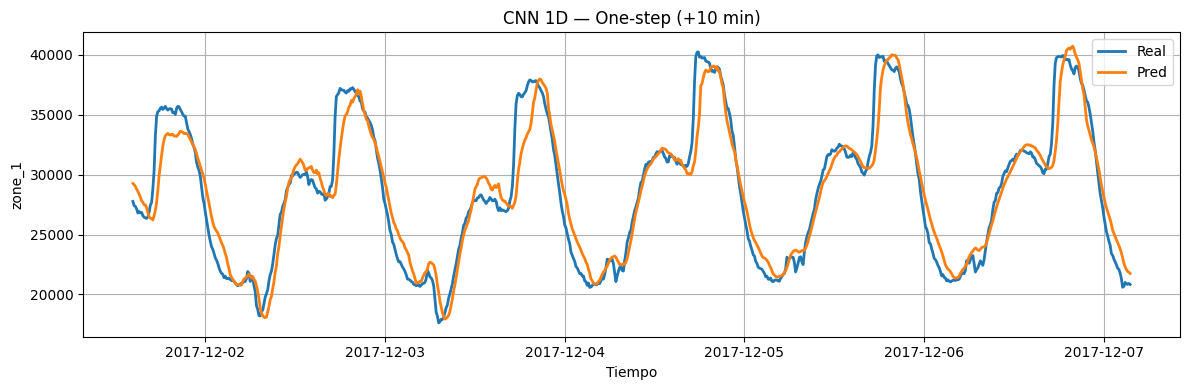

In [8]:
# Predicciones normalizadas
y_pred_val_cnn = cnn.predict(Xva, batch_size=512, verbose=0).reshape(-1)
y_pred_te_cnn  = cnn.predict(Xte, batch_size=512, verbose=0).reshape(-1)

# Invertir escala a unidades originales
y_val_inv_cnn      = inverse_target(yva, scalers)
y_pred_val_inv_cnn = inverse_target(y_pred_val_cnn, scalers)
y_te_inv_cnn       = inverse_target(yte, scalers)
y_pred_te_inv_cnn  = inverse_target(y_pred_te_cnn, scalers)

# Tramo de visualización en TEST
start = HISTORY_WINDOW + SHIFT_ONE_STEP - 1
idx_seg = test_df.index[start : start + len(y_te_inv_cnn)]

plot_segment(idx_seg[:800], y_te_inv_cnn[:800], y_pred_te_inv_cnn[:800],
             title="CNN 1D — One-step (+10 min)", target_name=TARGET_COL)

---

A múltiples pasos

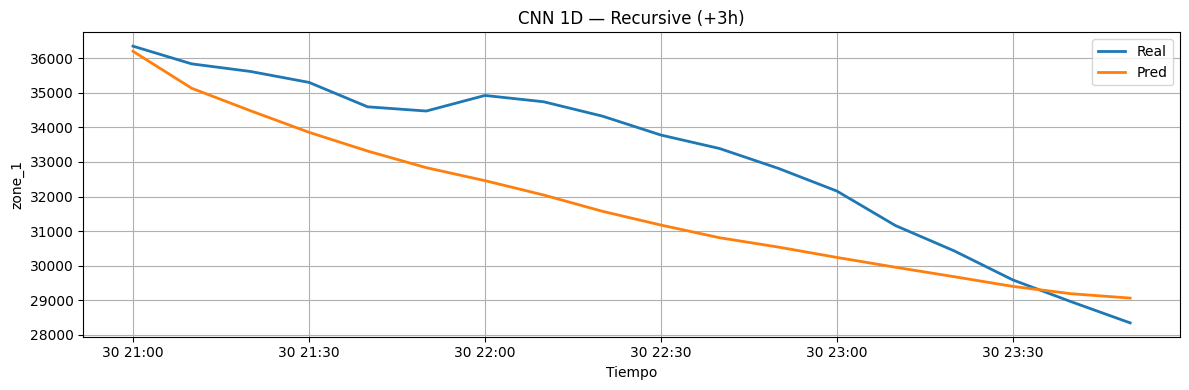

In [9]:
# ==============================================
# PRONÓSTICO A MÚLTIPLES PASOS — Recursive (3h)
# ==============================================
# Fundamento:
# - Autoregresivo: usar la predicción y_hat(t+1) como nuevo último lag para predecir t+2, etc.
# - Exógenas: por defecto estrategia HOLD (se mantienen fijas); si tienes pronósticos exógenos,
#   pásalos normalizados para reducir degradación (exog_future).
# - Para LSTM el input debe ser 3D: (1, HISTORY_WINDOW, F) en cada iteración.

def recursive_forecast_seq(
    model: keras.Model,
    seed_window: np.ndarray,           # (HISTORY_WINDOW, F) normalizado; orden: EXOG_COLS + [TARGET_COL]
    steps: int,
    exog_future: np.ndarray | None = None  # opcional: (steps, len(EXOG_COLS)) en escala normalizada
) -> np.ndarray:
    hist = seed_window.astype("float32").copy()
    preds = []
    for i in range(steps):
        x = hist[np.newaxis, :, :]                 # (1, H, F)
        y_hat = model.predict(x, verbose=0)[0, 0]  # escalar normalizado
        preds.append(y_hat)
        # Construimos la siguiente fila: exógenas hold o exog_future, target = y_hat
        next_row = hist[-1].copy()
        if exog_future is not None:
            next_row[:-1] = exog_future[i]        # reemplaza TODAS las exógenas
        # actualizar el target con la predicción
        next_row[-1] = y_hat
        # desplazar ventana
        hist = np.vstack([hist[1:], next_row])
    return np.array(preds, dtype="float32")

STEPS = 18  # 3 horas (18 * 10 min)
feats_order = EXOG_COLS + [TARGET_COL]

# Elegimos semilla en TEST dejando espacio para 'STEPS' futuros
seed_start = max(0, len(test_n) - (HISTORY_WINDOW + STEPS))
seed_end   = seed_start + HISTORY_WINDOW
seed_win   = test_n[feats_order].values[seed_start:seed_end]  # (H, F) normalizado

# Predicción recursiva (normalizada) y desnormalización
y_pred_rec_norm_cnn = recursive_forecast_seq(cnn, seed_win, STEPS, exog_future=None)
y_pred_rec_cnn      = inverse_target(y_pred_rec_norm_cnn, scalers)

# Verdaderos y eje temporal para evaluación homogénea
true_start = seed_end
true_end   = seed_end + STEPS
y_true_rec = test_df[TARGET_COL].values[true_start:true_end]
idx_future = test_df.index[true_start:true_end]

plot_segment(idx_future, y_true_rec, y_pred_rec_cnn,
             title="CNN 1D — Recursive (+3h)", target_name=TARGET_COL)

---

#### **Evaluación**

In [10]:
# One-step
smape_val_cnn = smape(y_val_inv_cnn, y_pred_val_inv_cnn)
wape_val_cnn  = wape(y_val_inv_cnn, y_pred_val_inv_cnn)
smape_te_cnn  = smape(y_te_inv_cnn,  y_pred_te_inv_cnn)
wape_te_cnn   = wape(y_te_inv_cnn,   y_pred_te_inv_cnn)

print(f"[CNN] ONE-STEP → VAL  sMAPE: {smape_val_cnn:.3f}% | WAPE: {wape_val_cnn:.3f}%")
print(f"[CNN] ONE-STEP → TEST sMAPE: {smape_te_cnn:.3f}% | WAPE: {wape_te_cnn:.3f}%")

# Recursive (+3h)
smape_rec_cnn = smape(y_true_rec, y_pred_rec_cnn)
wape_rec_cnn  = wape(y_true_rec, y_pred_rec_cnn)
print(f"[CNN] RECURSIVE (3h) → TEST sMAPE: {smape_rec_cnn:.3f}% | WAPE: {wape_rec_cnn:.3f}%")
print(f"[CNN] Training time: {t_train_cnn:.2f} segundos")


[CNN] ONE-STEP → VAL  sMAPE: 3.396% | WAPE: 3.344%
[CNN] ONE-STEP → TEST sMAPE: 4.336% | WAPE: 4.357%
[CNN] RECURSIVE (3h) → TEST sMAPE: 4.548% | WAPE: 4.475%
[CNN] Training time: 90.12 segundos


---

#### Referencias:
- Borovykh, A., Bohte, S., & Oosterlee, C. W. (2017).
"Conditional Time Series Forecasting with Convolutional Neural Networks"
ArXiv preprint: https://arxiv.org/abs/1703.04691

- Zhou, H., Zhang, S., Peng, J., Zhang, S., Li, J., Xiong, H., & Zhang, W. (2021).
"Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting"
AAAI 2021. https://arxiv.org/abs/2012.07436
lezas y limitaciones de CNN en escenarios multihorizonte.

- Lai, G., Chang, W. C., Yang, Y., & Liu, H. (2018).
"Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks" (LSTNet).
ACM SIGIR. https://doi.org/10.1145/3209978.3210006
